## **Explanatory Notebook**

##### By Daxton Furniss and Chase Maughan COMP 5960

# **Utah Fishing: A Data-Driven Guide to Utah's Top Fishing Spots**

## **Introduction**

#### Fishing is a popular and long-standing outdoor pastime, and Utah is known for its abundant rivers, lakes, and streams, teeming with a variety of fish. In recent decades, more people have taken up fishing across the state, and to support this, the Utah Division of Wildlife Resources (DWR) stocks local bodies of water to maintain healthy fish populations for food, sport, and recreation. With our shared interest in fishing, we aim to analyze fish stocking and distribution data published by the DWR to assess trends in sustainability, stocking practices, and the best fishing destinations, helping anglers find where to catch their favorite fish or enjoy abundant catches.

In [35]:
#Import necessary packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import geopandas as gpd
import folium
import ipywidgets as widgets
from IPython.display import display



#Import data from compiled .csv file 

fish_stock_data = pd.read_csv('Stocking_All_Years.csv')
fish_stock_data.rename(columns={'Spieces':'Species', 'Quanty':'Quantity'}, inplace=True) #Renaming misspelled column names 
fish_stock_data
#Combining data where only 'Quantity' value is different, to compile stock instances on same day

fish_stock_data = fish_stock_data.groupby(['Water Name', 'County', 'Species', 'Average Length', 'Date Stocked']).agg({"Quantity": 'sum'}).reset_index()
fish_stock_data
# Iterate through values in 'Water Name' and add corresponding water body type in new column

river_values = [' R']
pond_values = [' POND', ' P ', 'PARK', 'WPA', ' PND', ' PONDS', ' PD', ' Pond']
creek_values = [' CR', ' CREEK']
res_values = ['RES', 'Res', 'RESERVOIR', 'Reservoir']
lake_values = [' L', ' LAKES', ' LAKE', ' Lake']
fishery_values = [' FISHERY', ' Fishery', 'BLUE RIBBON']

for i, row in fish_stock_data.iterrows():
    water_name = row['Water Name']
    if any(value in water_name for value in fishery_values):
        fish_stock_data.at[i, 'Water Body Type'] = 'Fishery'
    elif any(value in water_name for value in res_values):
        fish_stock_data.at[i, 'Water Body Type'] = 'Reservoir'
    elif any(value in water_name for value in lake_values):
        fish_stock_data.at[i, 'Water Body Type'] = 'Lake'
    elif any(value in water_name for value in pond_values):
        fish_stock_data.at[i, 'Water Body Type'] = 'Pond'
    elif any(value in water_name for value in river_values):
        fish_stock_data.at[i, 'Water Body Type'] = 'River'
    elif any(value in water_name for value in creek_values):
        fish_stock_data.at[i, 'Water Body Type'] = 'Creek'
    else:
        fish_stock_data.at[i, 'Water Body Type'] = 'Other'

fish_stock_data['Date Stocked'] = pd.to_datetime(fish_stock_data['Date Stocked'])

fish_stock_data['Year'] = fish_stock_data['Date Stocked'].dt.year.astype('Int64')
fish_stock_data['Month'] = fish_stock_data['Date Stocked'].dt.month.astype('Int64')
fish_stock_data['Day'] = fish_stock_data['Date Stocked'].dt.day.astype('Int64')

In [26]:
#Adjusting altair default of 5000 rows maximum, to allow for greater number of rows in our dataset

alt.data_transformers.enable('default', max_rows=60000)

DataTransformerRegistry.enable('default')

In [27]:
# Number of unique water name locations
num_water_names = fish_stock_data['Water Name'].nunique()

# Number of unique species
num_species = fish_stock_data['Species'].nunique()

# Number of unique water body types
num_water_body_types = fish_stock_data['Water Body Type'].nunique()

# Average number of fish stocked per year
avg_fish_stocked_per_year = fish_stock_data.groupby('Year')['Quantity'].sum().mean()

# Creating a table to be used in explanatory notebook
summary_table = pd.DataFrame({
    'Utah Water, Fish, and Stocking Information': ['Number of Water Name Locations', 'Number of Species', 'Number of Water Body Types', 'Average Number of Fish Stocked per Year'],
    'Count': [num_water_names, num_species, num_water_body_types, avg_fish_stocked_per_year]
})

# Changing Value f
summary_table['Count'] = summary_table['Count'].apply(lambda x: f'{x:,.0f}')
summary_table.style.hide(axis="index")

"Utah Water, Fish, and Stocking Information",Count
Number of Water Name Locations,"1,257"
Number of Species,33
Number of Water Body Types,7
Average Number of Fish Stocked per Year,"9,684,444"


#### Utah is home to a wide variety of unique locations stocked with fish, offering anglers the chance to catch numerous species. On average, nearly 10 million fish are stocked annually across the state's waters, with hatcheries supplying just over 30 different species. We’ve analyzed the most popular fishing locations throughout Utah, helping both local and visiting anglers find the best spots to catch their desired species while staying within their limits.

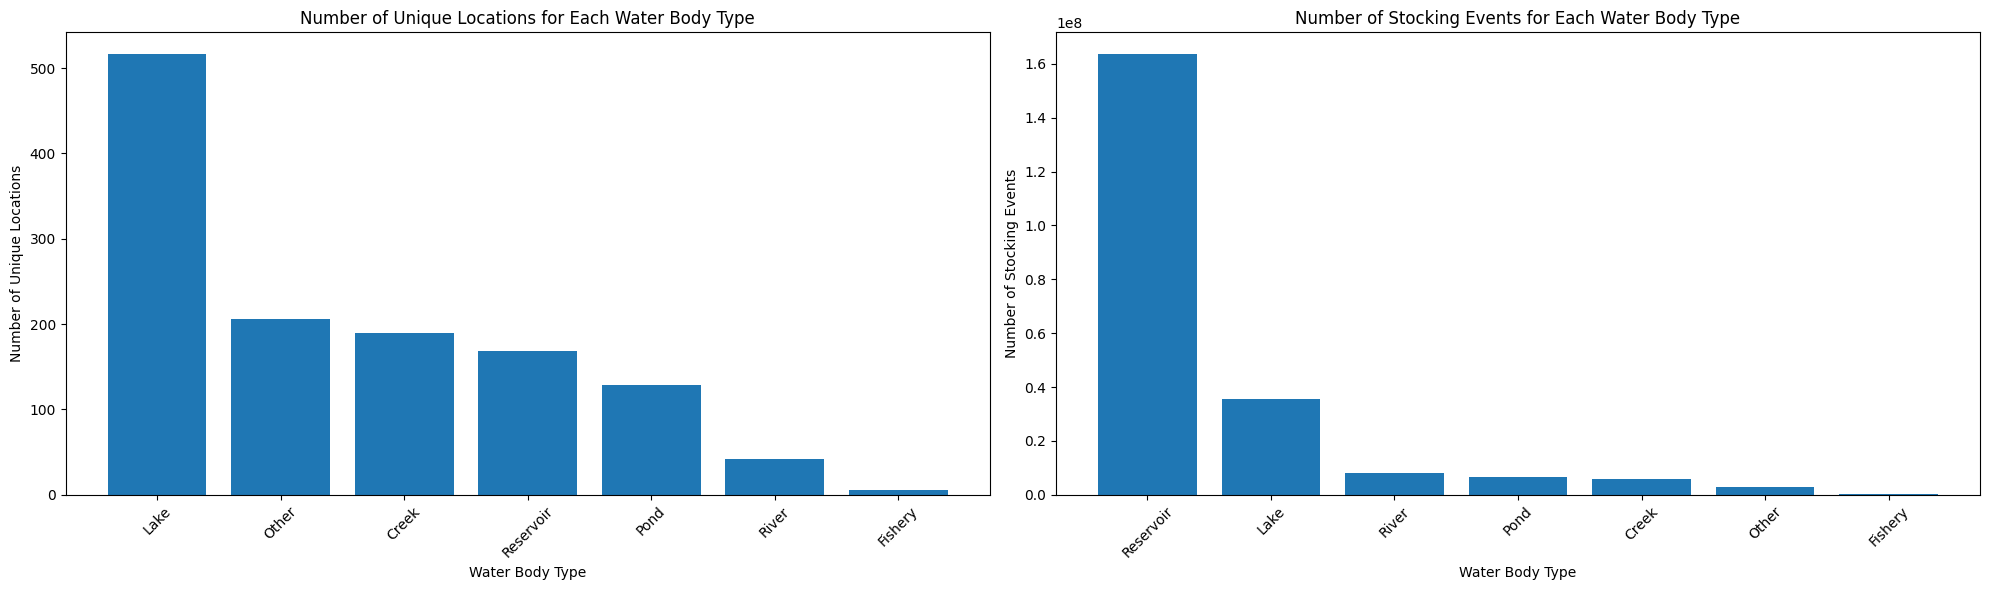

In [28]:
# Number of unique locations for each Water Body Type 
unique_instances_by_water_body_type = fish_stock_data.groupby('Water Body Type')['Water Name'].nunique().reset_index(name='Unique Instances')
unique_instances_by_water_body_type = unique_instances_by_water_body_type.sort_values(by='Unique Instances', ascending=False)

# Caveat is some may not be able to be classified fully correctly using character recognition, so sorted into 'Other' Category

# Total counts of instances each Water Body Type was stocked
top_water_body_types = fish_stock_data.groupby('Water Body Type')['Quantity'].sum().nlargest(7).reset_index(name='Top Water Body Types')

# Plotting the number of unique locations for each Water Body Type and the number of stocking events for each Water Body Type
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plotting the number of unique locations for each Water Body Type
axes[0].bar(unique_instances_by_water_body_type['Water Body Type'], unique_instances_by_water_body_type['Unique Instances'])
axes[0].set_title('Number of Unique Locations for Each Water Body Type')
axes[0].set_xlabel('Water Body Type')
axes[0].set_ylabel('Number of Unique Locations')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the number of stocking events for each Water Body Type
axes[1].bar(top_water_body_types['Water Body Type'], top_water_body_types['Top Water Body Types'])
axes[1].set_title('Number of Stocking Events for Each Water Body Type')
axes[1].set_xlabel('Water Body Type')
axes[1].set_ylabel('Number of Stocking Events')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

####  In Utah, the distribution of stocked fish plays a crucial role in shaping fishing experiences. The type of water and location you fish in affects many key factors, such as the gear, bait, and even accessibility. By identifying where these fish are being stocked, we aim to help anglers better prepare for their trips and increase their chances of a successful catch. Utah’s mountainous landscape, with ranges like the Wasatch and Uintas, is home to many small alpine lakes that are stocked every year to support local fish populations. However, these lakes don’t always receive large numbers of fish. In contrast, reservoirs—often larger and needing more fish to maintain their size—are the highest receivers of stocked fish. Over the past 20 years, reservoirs have been stocked thousands of times to meet these demands. Whether you're fishing at Flaming Gorge Reservoir or a smaller Uinta Lake, we hope to help both local and visiting anglers make the most of their fishing experience.

C:\Users\Chase\AppData\Local\Temp\ipykernel_12564\2199451649.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['entry_count'].fillna(0, inplace=True)


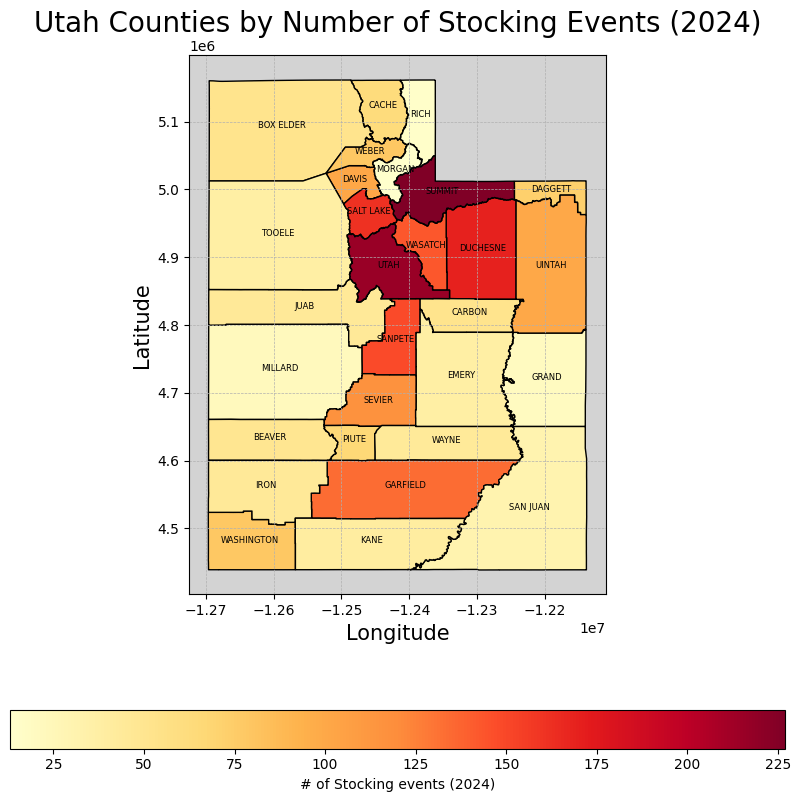

In [29]:
# Stocking data
csv_data = pd.read_csv('Stocking_All_Years.csv')

# Convert the 'Date Stocked' column to datetime format
csv_data['Date Stocked'] = pd.to_datetime(csv_data['Date Stocked'], format='%m/%d/%Y')

# Filter the data for the year 2024
csv_data_2024 = csv_data[csv_data['Date Stocked'].dt.year == 2024]

# Count the number of entries per county in 2024
county_counts_2024 = csv_data_2024['County'].value_counts().reset_index()
county_counts_2024.columns = ['NAME', 'entry_count']  # Rename columns for merging

# Load the shapefile for Utah counties
gdf = gpd.read_file('Counties/Counties.shp')

# Merge the county counts for 2024 with the GeoDataFrame based on the 'NAME' column
gdf = gdf.merge(county_counts_2024, on='NAME', how='left')

# Replace NaN values (counties with no entries in the CSV) with 0
gdf['entry_count'].fillna(0, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the counties with a color scale based on 'entry_count'
gdf.plot(ax=ax, column='entry_count', cmap='YlOrRd', edgecolor='black', legend=True,
         legend_kwds={'label': "# of Stocking events (2024)", 'orientation': "horizontal"})

# Add county names
for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['NAME']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')

# Set titles and labels
ax.set_title("Utah Counties by Number of Stocking Events (2024)", fontsize=20)
ax.set_xlabel("Longitude", fontsize=15)
ax.set_ylabel("Latitude", fontsize=15)

# Customize grid and background
ax.grid(True, linestyle='--', linewidth=0.5)
ax.set_facecolor('lightgrey')

# Show the plot
plt.show()

#### The idea that fishermen tend to fish in easily accessible bodies of water, such as reservoirs, is further confirmed through a heat map showing stocking events by county. This map reveals that most stocking events occur in highly populated areas, where fishing activity is concentrated. To keep fish populations healthy in these popular locations, more fish need to be stocked to meet the demand.

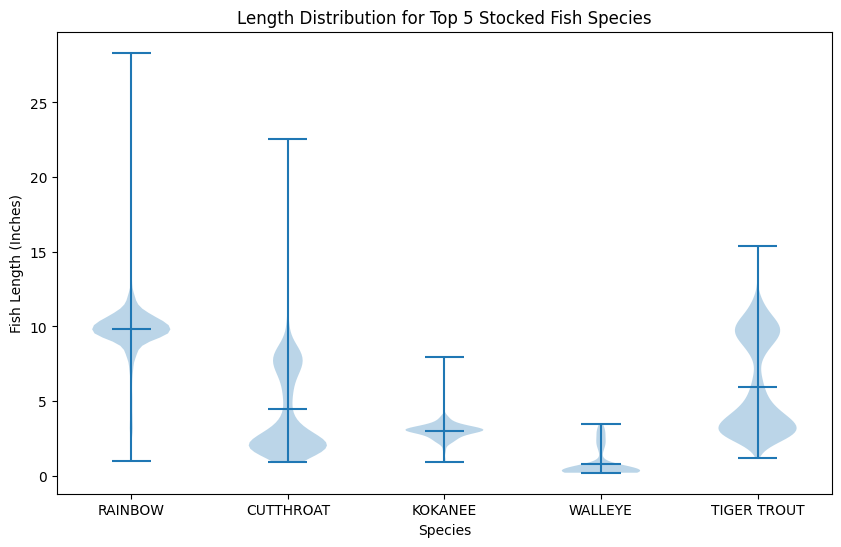

In [30]:
#Selecting only top 5 fish that were stocked the most
species_filter = ['RAINBOW', 'CUTTHROAT', 'KOKANEE', 'WALLEYE', 'TIGER TROUT']
filtered_data = fish_stock_data[fish_stock_data['Species'].isin(species_filter)]

plt.figure(figsize=(10, 6))
plt.violinplot([filtered_data[filtered_data['Species'] == species]['Average Length'] for species in species_filter], showmeans=True)
plt.title('Length Distribution for Top 5 Stocked Fish Species')
plt.xlabel('Species')
plt.ylabel('Fish Length (Inches)')
plt.xticks(ticks=range(1, len(species_filter) + 1), labels=species_filter)
plt.show()

#### The most popular fish stocked in Utah over the past 20 years include the Rainbow Trout, Cutthroat Trout, Kokanee Salmon, Walleye, and Tiger Trout. These species are highly sought after by both regular fishermen, who enjoy them for their taste and display qualities, and trophy fishermen, who target them for their potential to yield large catches.

#### When stocking these species, the DWR aims to stock adult fish grown in local fish hatcheries. This ensures that fishing opportunities are available shortly after stocking. Fish stocked in Utah waters range from slightly younger minnows to older adults. Since most fish raised in hatcheries are sterile, elderly fish and very young minnows are typically not included in the average stocking range.

#### Among the most popular fish, Rainbow Trout are typically stocked around 10 inches in size across Utah. This is a good size that allows them to grow further, and occasionally, larger specimens up to 26+ inches are stocked. Cutthroat Trout are also stocked at a larger size, making them immediately available for local anglers. These fish are stocked at larger sizes because studies have shown that when more money is spent growing them to a bigger size in hatcheries, more fishermen are able to catch them, making it more cost-effective than stocking a large number of minnows.

#### On the other hand, fish like Kokanee Salmon and Walleye perform better in the wild when introduced as fingerlings. As a result, hatcheries spend less money and time growing them before stocking, as these species thrive when stocked at a younger, smaller size.

## **How Historical Stocking Trends Influence Utah Fishing**

In [31]:
#Grouping appropriate data
count_by_species = fish_stock_data.groupby(['Year', 'Species'])['Quantity'].sum().reset_index()
count_by_species["Year_only"] = count_by_species["Year"]

#Interactive Year Slider
year_slider = alt.binding_range(name="Select a year : ", min=count_by_species["Year_only"].min(), max=count_by_species["Year_only"].max(), step=1)
selected_year =  alt.selection_point(fields=["Year_only"], bind=year_slider, value=2024)

#Interactive Species Point and Brush Selection 
point_selection = alt.selection_point(fields=['Species'])
brush_selection = alt.selection_interval(encodings=['x'])

#Adding base plot
base_plot = alt.Chart(count_by_species)

#Color
color = alt.condition(
    brush_selection & point_selection,
    alt.Color('Species:N', scale=alt.Scale(scheme='category20'), legend=None),
    alt.value('lightgray')
)

#Tooltip
tooltip = alt.Tooltip(
    ["Species:N", "Year:O", "Quantity:Q"]
)

#Bar Chart Vis
bar_chart = base_plot.mark_bar().encode(
    x=alt.X('Species', axis=alt.Axis(labelAngle=-45), sort=None),
    y='Quantity', 
    color=color,
    tooltip=tooltip
).properties(
    width=600,
    height=400,
    title='Number of Stocked Fish by Species'
).transform_filter(
    selected_year
).add_params(
    selected_year, 
    point_selection,
    brush_selection,
)

#Line Chart Vis
line_chart = base_plot.mark_line().encode(
    x=alt.X('Year:O', axis=alt.Axis(labelAngle=-45)),
    y='Quantity', 
    color=color, 
    tooltip=tooltip
).properties(
    width=600,
    height=400,
    title='Number of Stocked Fish by Species'
).transform_filter(
    point_selection
).add_params(
    brush_selection,
    point_selection
)

#Stacking both charts together 
temporal_chart = alt.hconcat(line_chart, bar_chart).resolve_scale()
temporal_chart

alt.HConcatChart(...)

#### To understand the current state and future of fishing in Utah, we must examine how historical trends have shaped the state's waters. The Utah DWR plays a key role in adjusting the number of fish stocked each year by tracking trends in current fish populations and ensuring the ecosystem is not overloaded. By monitoring these trends, they can adjust stocking numbers accordingly. This interactive chart allows us to explore how some of Utah's most popular fish have been stocked over time.

#### From our historical data, we can observe trends in the stocking of popular fish such as Rainbow and Cutthroat Trout. Over the past 20 years, the stocking numbers for these species have decreased, partly due to changes in the DWR's stocking pattern. The DWR has shifted to stocking fewer, but larger fish to improve survival rates and adapt to challenges such as rising drought conditions and decreasing water levels in recent years.

#### In contrast, some species, like Kokanee Salmon and Walleye, have seen a general upward trend in stocking numbers. For most other fish species, stocking levels have remained relatively stable, adjusting up or down based on yearly needs and conditions.


In [32]:
#Include all missing dates
all_dates = pd.date_range(start=fish_stock_data['Date Stocked'].min(), end=fish_stock_data['Date Stocked'].max(), freq='D')
complete_dates_df = pd.DataFrame(all_dates, columns=['Date Stocked'])
complete_dates_df['Year'] = complete_dates_df['Date Stocked'].dt.year
complete_dates_df['Month'] = complete_dates_df['Date Stocked'].dt.month
complete_dates_df['Day'] = complete_dates_df['Date Stocked'].dt.day

daily_counts = fish_stock_data.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Daily Stocking Count')
merged_counts = pd.merge(complete_dates_df, daily_counts, on=['Year', 'Month', 'Day'], how='left').fillna(0)

avg_daily_counts = merged_counts.groupby(['Month', 'Day'])['Daily Stocking Count'].mean().reset_index()
avg_daily_counts = avg_daily_counts.rename(columns={'Daily Stocking Count': 'Daily Stocking Average'})

yearly_counts = fish_stock_data.groupby('Year').size().reset_index(name='Yearly Stocking Count')

heatmap_combined_df = pd.merge(merged_counts, yearly_counts, on='Year', how='left')
heatmap_combined_df = pd.merge(heatmap_combined_df, avg_daily_counts, on=['Month', 'Day'], how='left')

brush_selection = alt.selection_point(encodings=['x', 'y'])

base_plot = alt.Chart(heatmap_combined_df)

# Heatmap
heatmap = base_plot.mark_rect().encode(
    x=alt.X("Day:O", title="Day"),
    y=alt.Y("Month:O", title="Month"),
    color=alt.condition(
        brush_selection,
        alt.Color("Daily Stocking Average:Q", title="Avg Daily Stocking", legend=None),
        alt.value("lightgray")
    ),
    tooltip=['Month:O', 'Day:O', 'Daily Stocking Average:Q']
).add_params(
    brush_selection
).properties(
    title='Average Stocking Count by Date',
    height=400,
    width=800
)

heatmap

alt.Chart(...)

#### Now that we understand the background and trends of fish stocking in Utah, we can focus on the best times to catch fish—when the fish population is most dense. Stocking primarily occurs during the summer months, from June to August, when access to stocking locations is easier and the waters are free of ice. Stocking fish in warm water environments during summer enhances their survival rates and helps them adapt more quickly to their new surroundings. The peak stocking period is from the last week of June through the first week of July, making it the ideal time to visit your favorite fishing spots or explore new areas for freshly stocked fish.

#### While many fish are stocked in the summer, pre-existing fish can still be caught throughout the year, and ice fishing remains popular in the winter months. For anglers not focused on trophy fish or keeping their catch, the newly stocked fish offer a great opportunity for catch-and-release fishing. This time also provides an excellent chance to enjoy a long day of fishing, teach new fishermen the ropes, or experiment with different bait for a successful outing.

## **How to Find Where to Go Fishing**

In [33]:
# Average quantity of fish stocked per location
average_quantity_by_water = (
    fish_stock_data.groupby(['Water Name'])['Quantity'].mean().reset_index()
)
average_quantity_by_water.rename(columns={'Quantity': 'Avg_Quantity'}, inplace=True)

# Top 50 water locations
top_50_water_names = (
    fish_stock_data.groupby(['Water Name'])['Quantity'].sum()
    .nlargest(50)
    .index
)

# Filter the data to include the top 50 water names
filtered_data = fish_stock_data[
    fish_stock_data['Water Name'].isin(top_50_water_names)
]

# Default to the first species
default_species = sorted(fish_stock_data['Species'].unique())[0]

# Dropdown selection
species_dropdown = alt.binding_select(
    name='Select a Species: ',
    options=sorted(fish_stock_data['Species'].unique()),
)
species_selection = alt.selection_point(fields=['Species'], bind=species_dropdown, value=default_species)

chart_data = filtered_data.groupby(['Water Name', 'Species'])['Quantity'].mean().reset_index()
chart_data.rename(columns={'Quantity': 'Avg_Quantity'}, inplace=True)

# Bar Chart
bar_chart = alt.Chart(chart_data).mark_bar().encode(
    x=alt.X(
        'Water Name:N', 
        sort=None, 
        axis=alt.Axis(labelAngle=-45), 
        title='Top 50 Stocked Locations',
        scale=alt.Scale(domain=filtered_data['Water Name'].unique(), paddingInner=0.1)
    ),
    y=alt.Y('Avg_Quantity:Q', title='Average Stocked Fish Count'),
    color=alt.condition(
        species_selection,
        alt.Color('Species:N', legend=None, scale=alt.Scale(scheme='category20')),
        alt.value('lightgray')
    ),
    tooltip=['Water Name', 'Species', 'Avg_Quantity']
).transform_filter(
    species_selection
).properties(
    width=800,
    height=400,
    title='Top 50 Locations of Average Yearly Stocked Fish Quantity, by Species'
).add_params(
    species_selection
)
bar_chart


alt.Chart(...)

#### Utah has many various lakes, reservoirs, and waterways. In order to find the type of fish angleres are looking for, we developed a tool to find where each fish species is distributed across the top 50 most stocked locations across Utah. Depending on the species, this tool will help locate the areas in Utah that are, on average, stocked the most with whatever fish species fishermen are looking for. For example, say a fishermen is traveling to Utah to fish for Cutthroat Trout, the only trout species that is native to Utah. We can see that many top locations are stocked with Cutthroat, and places like East Canyon Reservoir and Whitney Reservoir are stocked more. These are great places to enjoy catching some unique trout. Once the best area to go fishing is found, users can also easily locate the area in our map of Utah below, to better guide outdoorsmen to enjoy fishing in this beautiful state. 

# Interacitve map with all stocked water bodies in the state of Utah

### 

In [36]:
# Stocking CSV file 
csv_data_1 = pd.read_csv('Stocking_All_Years.csv')

# Output CSV file w geocodes
csv_data_2 = pd.read_csv('output_with_geocodes.csv')  # Replace with the actual file name

# Merge the two dataframes on the 'Water Name' column
merged_data = pd.merge(csv_data_1, csv_data_2, on='Water Name', how='inner')

# Ensure 'Year' column exists in merged_data
if 'Year' not in merged_data.columns:
    merged_data['Year'] = pd.to_datetime(merged_data['Date Stocked_x']).dt.year

# Function to create the map for a specific year
def create_map(year):
    # Create a map centered on Utah
    utah_map = folium.Map(location=[39.3210, -111.0937], zoom_start=7)
    
    # Filter the data for the selected year
    year_data = merged_data[merged_data['Year'] == year]
    
    # Group the data by 'Water Name' and 'Species'
    grouped_data = year_data.groupby(['Water Name', 'Spieces_x']).agg({
        'County_x': 'first',
        'Quanty_x': 'sum',
        'Latitude': 'first',
        'Longitude': 'first'
    }).reset_index()
    
    # Add the merged data points to the map
    for water_name, group in grouped_data.groupby('Water Name'):
        # Combine the information for the popup
        popup_info = "<br>".join(
            f"<br>{row['Spieces_x']}<br>Quantity: {row['Quanty_x']}"
            for idx, row in group.iterrows()
        )
        # Use the first row's location for the marker
        first_row = group.iloc[0]
        folium.CircleMarker(
            location=[first_row['Latitude'], first_row['Longitude']],
            radius=2,
            popup=f"{water_name}<br>{popup_info}",
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(utah_map)
    
    return utah_map

# Create the slider widget for selecting the year
year_slider = widgets.IntSlider(
    value=2024,
    min=merged_data['Year'].min(),
    max=merged_data['Year'].max(),
    step=1,
    description='Year:',
    continuous_update=False
)

# Create an output widget to display the map
output = widgets.Output()

# Function to update the map based on the selected year
def on_year_change(change):
    with output:
        # Clear the previous output
        output.clear_output(wait=True)
        
        # Display the updated map
        updated_map = create_map(change.new)
        display(updated_map)

# Link the slider to the update function
year_slider.observe(on_year_change, names='value')

# Display the slider and the output widget
display(year_slider, output)

# Initially display the map for the first year
with output:
    initial_map = create_map(year_slider.value)
    display(initial_map)

IntSlider(value=2024, continuous_update=False, description='Year:', max=2024, min=2002)

Output()

Finally, Dive into our interactive map and look up your favorite fishing spots to discover which species are being stocked—and even better, how many! Use the slider, to explore how stocking patterns have evolved over the last 20 years and uncover exciting trends that could make your next fishing trip even more rewarding!